In [ ]:
# VQGAN Resource: https://ljvmiranda921.github.io/notebook/2021/08/08/clip-vqgan/

In [112]:
import glob
import string

from einops import rearrange
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision.utils import save_image

from models import *

%matplotlib inline

In [20]:
CHAR_SET = list(string.ascii_lowercase) + [' ']
MAX_TURNS = 3
MAX_OUTPUT_LENGTH = 64
IMG_DIM = (3, 64, 64) # (3, 256, 256)
DEVICE = 'cuda'

In [83]:
# Discriminator params
disc_kernels = [3, 3, 3, 3, 3, 3, 3]
disc_filters = [16, 32, 64, 64, 128, 128, 1]
disc_strides = [1, 2, 2, 2, 1, 1, 1]

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()

        # 3 x 64 x 64 input
        self.in_filters = 1 * input_dim[0] # 2 * input_dim[0]

        ### Downscale ###

        self.layer1 = nn.Sequential(
            nn.Conv2d(self.in_filters, disc_filters[0], kernel_size=disc_kernels[0],
                      stride=disc_strides[0], padding=(disc_kernels[0]-1)//2),
            nn.LeakyReLU(),
            nn.Dropout(0.4))
        self.layer2 = nn.Sequential(
            nn.Conv2d(disc_filters[0], disc_filters[1], kernel_size=disc_kernels[1],
                      stride=disc_strides[1], padding=(disc_kernels[1]-1)//2),
            nn.LeakyReLU(),
            nn.Conv2d(disc_filters[1], disc_filters[2], kernel_size=disc_kernels[2],
                      stride=disc_strides[2], padding=(disc_kernels[2]-1)//2),
            nn.BatchNorm2d(disc_filters[2]),
            nn.LeakyReLU(),
            nn.Dropout(0.4))
        self.layer3 = nn.Sequential(
            nn.Conv2d(disc_filters[2], disc_filters[3], kernel_size=disc_kernels[3],
                      stride=disc_strides[3], padding=(disc_kernels[3]-1)//2),
            nn.LeakyReLU(),
            nn.Conv2d(disc_filters[3], disc_filters[4], kernel_size=disc_kernels[4],
                      stride=disc_strides[4], padding=(disc_kernels[4]-1)//2),
            nn.BatchNorm2d(disc_filters[4]),
            nn.LeakyReLU(),
            nn.Dropout(0.4))
        self.layer4 = nn.Sequential(
            nn.Conv2d(disc_filters[4], disc_filters[5], kernel_size=disc_kernels[5],
                      stride=disc_strides[5], padding=(disc_kernels[5]-1)//2),
            nn.BatchNorm2d(disc_filters[5]),
            nn.LeakyReLU(),
            nn.Dropout(0.4))
        self.layer5 = nn.Conv2d(disc_filters[5], disc_filters[6], kernel_size=disc_kernels[6],
            stride=disc_strides[6], padding=(disc_kernels[6]-1)//2)

        self.convs_layers = nn.Sequential(
            self.layer1,
            self.layer2,
            self.layer3,
            self.layer4,
            self.layer5)

        test_input = torch.zeros(1, self.in_filters, input_dim[1], input_dim[2])
        output_shape = self.convs_layers(test_input).shape

        self.layer6 = nn.Sequential(
            nn.Linear(disc_filters[6] * output_shape[2] * output_shape[3], 1))
    
    def forward(self, x):
        z = self.convs_layers(x).view(x.shape[0], -1)
        prob = self.layer6(z)
        
        return prob

    # def forward(self, x, y):
    #     x = torch.cat((x, y), dim=1)
    #     z = self.convs_layers(x).view(x.shape[0], -1)
    #     prob = self.layer6(z)
        
    #     return prob

In [84]:
class Generator(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

    def forward(self, orig_img, curr_img=None):
        if curr_img is None:
            curr_img = torch.zeros_like(orig_img)
        
        logits = self.encoder(orig_img, curr_img)
        out_img = self.decoder(logits)
        out_img += curr_img
        return torch.clamp(out_img, 0, 1)

In [85]:
def display_img(img):
    plt.imshow(img.permute(1, 2, 0))

In [87]:
dataset = make_dataset('data/', IMG_DIM)

In [89]:
encoder = Encoder(IMG_DIM)
test_img = torch.rand((2, 3, 64, 64))
logits = encoder(test_img, test_img)
print(logits.shape)
decoder = Decoder(IMG_DIM)
out_img = decoder(logits)
print(out_img.shape)
gen = Generator(encoder, decoder)
out_img = gen(test_img, test_img)
print(out_img.shape)
disc = Discriminator(IMG_DIM)
test_input = torch.randn(1, *IMG_DIM)
# print(disc(test_input, test_input).shape)
print(disc(test_input).shape)

torch.Size([2, 27, 2, 2])
torch.Size([2, 3, 64, 64])
torch.Size([2, 3, 64, 64])
torch.Size([1, 1])


In [90]:
# Training params
n_epochs = 50
batch_size = 32
log_freq = 100
lr = 2e-5
min_steps = 1
max_steps = 3

In [91]:
encoder = Encoder(IMG_DIM).to(DEVICE)
decoder = Decoder(IMG_DIM).to(DEVICE)
generator = Generator(encoder, decoder).to(DEVICE)
disc = Discriminator(IMG_DIM).to(DEVICE)

In [81]:
# encoder = torch.load('encoder_v4.model')
# decoder = torch.load('decoder_v4.model')

In [121]:
lr = 0.00005

n_epochs = 10000
n_critic = 5
batch_cycle_size = n_critic + 1
log_freq = 250
img_output_dir = './training_imgs'
for f in glob.glob(img_output_dir + '/*'):
    os.remove(f)

gen_optimizer = optim.RMSprop(generator.parameters(), lr=lr, momentum=0)
disc_optimizer = optim.RMSprop(disc.parameters(), lr=lr, momentum=0)

gen_loss_hist = []
disc_loss_hist = []
for epoch in range(n_epochs):
    dataset.shuffle()
    data_iter = dataset.get_batch_iter(batch_size)
    log_loss_steps = 0

    for batch_idx, orig_img_batch in enumerate(data_iter):
        orig_img_batch = orig_img_batch.to(DEVICE)

        # Check whether to update the generator or critic
        if batch_idx % batch_cycle_size == 0:
            # Update generator
            latent_sample = torch.randn(batch_size, *IMG_DIM).to(DEVICE)
            gen_img_batch = generator(latent_sample)
            discrim_logits = disc(gen_img_batch)
            gen_loss = -torch.mean(discrim_logits)

            gen_optimizer.zero_grad()
            gen_loss.backward()
            gen_optimizer.step()

            gen_loss_hist.append(gen_loss.item())
        else:
            # Update critic
            latent_sample = torch.randn(batch_size, *IMG_DIM).to(DEVICE)
            disc_loss = -(torch.mean(disc(orig_img_batch)) - \
                torch.mean(disc(generator(latent_sample))))

            disc_optimizer.zero_grad()
            disc_loss.backward()
            disc_optimizer.step()

            disc_loss_hist.append(disc_loss.item())

            with torch.no_grad():
                for params in disc.parameters():
                    params.data.clamp_(-0.01, 0.01)
        
        # Ocasionally print losses
        if (batch_idx + 1) % log_freq == 0:
            print('Gen loss: {:.4f} | Disc loss: {:.4f}'.format(
                np.mean(gen_loss_hist[-(log_freq//batch_cycle_size):]),
                np.mean(disc_loss_hist[-(log_freq - (log_freq//batch_cycle_size)):])))
            save_image(orig_img_batch[0], os.path.join(img_output_dir,
                '{}_orig.png'.format((epoch + 1) * batch_idx + 1)))
            save_image(gen_img_batch[0], os.path.join(img_output_dir,
            '{}_gen.png'.format((epoch + 1) * batch_idx + 1)))
            
            

Gen loss: 0.0520 | Disc loss: -0.0932
Gen loss: 0.0520 | Disc loss: -0.0930
Gen loss: 0.0519 | Disc loss: -0.0928
Gen loss: 0.0517 | Disc loss: -0.0906
Gen loss: 0.0513 | Disc loss: -0.0904
Gen loss: 0.0515 | Disc loss: -0.0915
Gen loss: 0.0491 | Disc loss: -0.0897
Gen loss: 0.0514 | Disc loss: -0.0911
Gen loss: 0.0497 | Disc loss: -0.0879
Gen loss: 0.0489 | Disc loss: -0.0889
Gen loss: 0.0364 | Disc loss: -0.0720
Gen loss: 0.0440 | Disc loss: -0.0806
Gen loss: 0.0511 | Disc loss: -0.0859
Gen loss: 0.0466 | Disc loss: -0.0844
Gen loss: 0.0413 | Disc loss: -0.0774
Gen loss: 0.0513 | Disc loss: -0.0875
Gen loss: 0.0506 | Disc loss: -0.0915
Gen loss: 0.0387 | Disc loss: -0.0744
Gen loss: 0.0480 | Disc loss: -0.0908
Gen loss: 0.0515 | Disc loss: -0.0849
Gen loss: 0.0514 | Disc loss: -0.0908
Gen loss: 0.0480 | Disc loss: -0.0882
Gen loss: 0.0513 | Disc loss: -0.0894
Gen loss: 0.0512 | Disc loss: -0.0798
Gen loss: 0.0514 | Disc loss: -0.0907
Gen loss: 0.0516 | Disc loss: -0.0928
Gen loss: 0.

KeyboardInterrupt: 

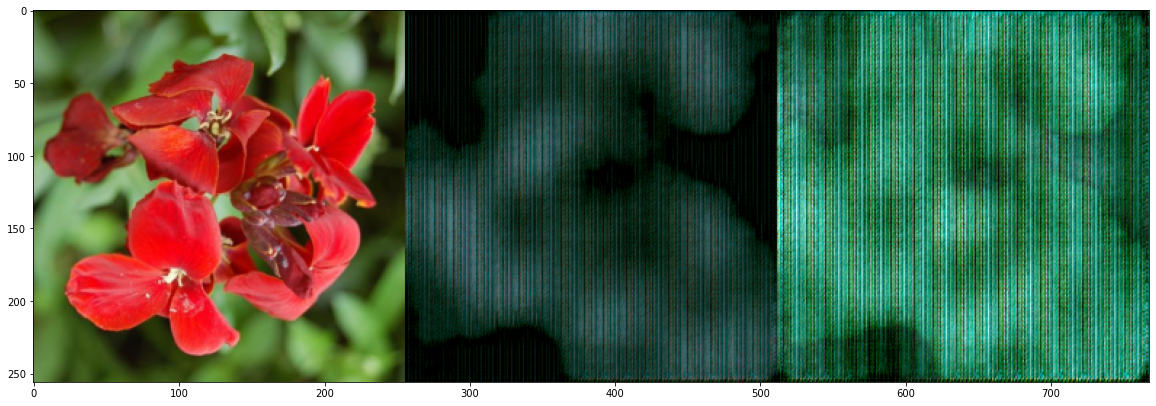

In [22]:
test_batch_size = 1

dataset.shuffle()
data_iter = dataset.get_batch_iter(test_batch_size)
orig_img_batch = next(data_iter).cuda()

# Prep data
curr_img_batch = torch.zeros_like(orig_img_batch)

gen_imgs = []
for step in range(max_steps):
    logits = encoder(orig_img_batch, curr_img_batch)
    gen_img_batch = torch.clamp(decoder(logits) + curr_img_batch.detach(), 0, 1)
    curr_img_batch = gen_img_batch.detach()
    gen_imgs.append(gen_img_batch[0].detach().cpu())
    curr_img_batch = gen_img_batch.detach()

# logits = encoder(orig_img_batch, orig_img_batch)
# gen_img_batch = decoder(logits)
plt.figure(figsize=(20,20))
combined_img = torch.cat([orig_img_batch[0].cpu(), gen_imgs[0], gen_imgs[-1]], axis=2)
display_img(combined_img)

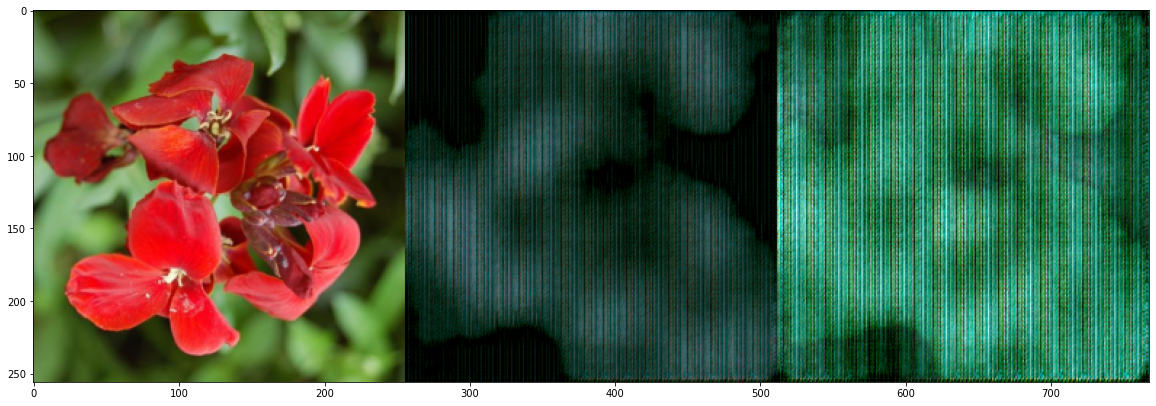

In [23]:
plt.figure(figsize=(20,20))
combined_img = torch.cat([orig_img_batch[0].cpu(), gen_imgs[0], gen_imgs[-1]], axis=2)
display_img(combined_img)

In [150]:
with open('encoder_final.model', 'wb') as f:
    torch.save(encoder, f)
    
with open('decoder_final.model', 'wb') as f:
    torch.save(decoder, f)